In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['11CA','total'])
    lista_ine2.append(ine_ods[date].loc['33PO','total'])
    lista_ine3.append(ine_ods[date].loc['026V','total'])
    lista_ine4.append(ine_ods[date].loc['21BU','total'])
    lista_ine5.append(ine_ods[date].loc['49GI','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,194
2020-04-02,183
2020-04-03,317
2020-04-04,177
2020-04-05,142


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,366.592593
std,108.663446
min,110.000000
25%,303.000000
50%,390.000000
75%,433.000000
max,614.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,276.233333
2020-05-31,402.096774
2020-06-30,447.100000


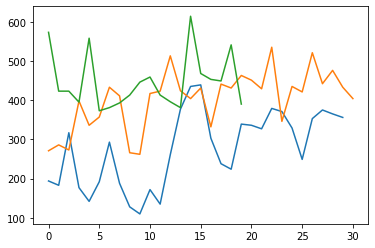

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.16666667 0.14484127 0.41071433 0.13293652 0.06349207 0.16269843
  0.36309528]
 [0.14484127 0.41071433 0.13293652 0.06349207 0.16269843 0.36309528
  0.1547619 ]
 [0.41071433 0.13293652 0.06349207 0.16269843 0.36309528 0.1547619
  0.03571428]
 [0.13293652 0.06349207 0.16269843 0.36309528 0.1547619  0.03571428
  0.        ]
 [0.06349207 0.16269843 0.36309528 0.1547619  0.03571428 0.
  0.12301587]
 [0.16269843 0.36309528 0.1547619  0.03571428 0.         0.12301587
  0.04960318]
 [0.36309528 0.1547619  0.03571428 0.         0.12301587 0.04960318
  0.29960322]
 [0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
  0.52976197]
 [0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
  0.6448413 ]
 [0.         0.12301587 0.04960318 0.29960322 0.52976197 0.6448413
  0.65277785]
 [0.12301587 0.04960318 0.29960322 0.52976197 0.6448413  0.65277785
  0.38293654]
 [0.04960318 0.29960322 0.52976197 0.6448413  0.65277785 0.38293654
  0.25396824]
 [0.29960322 0.52976197 0.

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.16666667]
  [0.14484127]
  [0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]]

 [[0.14484127]
  [0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]]

 [[0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]]

 [[0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]]

 [[0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]]

 [[0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]]

 [[0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]]

 [[0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]
  [0.52976197]]

 [[0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]
  [0.52976197]
  [0.6448413 ]]

 [[0.        ]
  [0.12301587]
  [0.04

In [23]:
print(trainY)

[0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
 0.52976197 0.6448413  0.65277785 0.38293654 0.25396824 0.22619049
 0.45436513 0.44841272 0.43055558 0.5337302  0.5178572  0.43452382
 0.27579367 0.48214293 0.5257937  0.5059524  0.48809528 0.31944448
 0.3492064  0.32341272 0.5714286  0.44841272 0.4900794  0.6408731
 0.59722227 0.30952382 0.30158734 0.60912704 0.6210318  0.7996032
 0.62301594 0.5833334  0.63690484 0.44047624 0.6567461  0.63690484
 0.7003969  0.67658734 0.63293654 0.84325397 0.46825403 0.6448413
 0.6170635  0.8154763  0.6587302  0.7261905  0.6408731 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0142 - val_loss: 0.0173
Epoch 124/200
53/53 - 0s - loss: 0.0155 - val_loss: 0.0171
Epoch 125/200
53/53 - 0s - loss: 0.0125 - val_loss: 0.0175
Epoch 126/200
53/53 - 0s - loss: 0.0128 - val_loss: 0.0170
Epoch 127/200
53/53 - 0s - loss: 0.0143 - val_loss: 0.0170
Epoch 128/200
53/53 - 0s - loss: 0.0163 - val_loss: 0.0239
Epoch 129/200
53/53 - 0s - loss: 0.0156 - val_loss: 0.0175
Epoch 130/200
53/53 - 0s - loss: 0.0152 - val_loss: 0.0194
Epoch 131/200
53/53 - 0s - loss: 0.0149 - val_loss: 0.0198
Epoch 132/200
53/53 - 0s - loss: 0.0145 - val_loss: 0.0193
Epoch 133/200
53/53 - 0s - loss: 0.0148 - val_loss: 0.0176
Epoch 134/200
53/53 - 0s - loss: 0.0160 - val_loss: 0.0188
Epoch 135/200
53/53 - 0s - loss: 0.0153 - val_loss: 0.0177
Epoch 136/200
53/53 - 0s - loss: 0.0148 - val_loss: 0.0189
Epoch 137/200
53/53 - 0s - loss: 0.0145 - val_loss: 0.0171
Epoch 138/200
53/53 - 0s - loss: 0.0157 - val_loss: 0.0167
Epoch 139/200
53/53 - 0s - loss: 0.0158 - val_loss: 0.01

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 39.40 MAE
Resultado del entrenamiento: 2465.74 MSE
Resultado del entrenamiento: 49.66 RMSE
Resultado del entrenamiento: 13.96 CVRMSE
Resultado del entrenamiento: 12.23 MAPE 

Resultado del test: 46.29 MAE
Resultado del test: 4576.79 MSE
Resultado del test: 67.65 RMSE
Resultado del test: 15.28 CVRMSE
Resultado del test: 9.68 MAPE


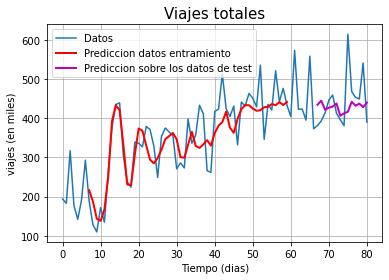

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

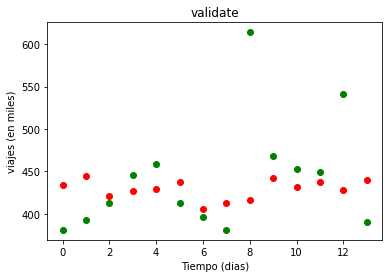

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

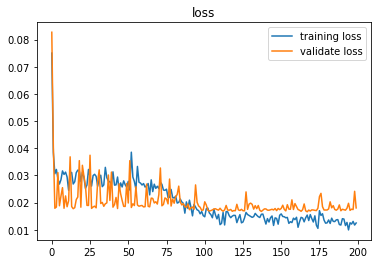

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

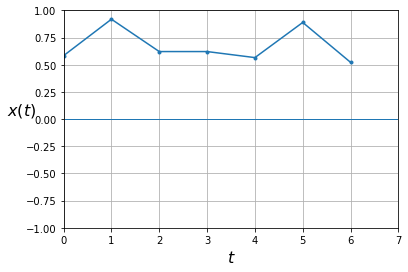

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,434.179779
2020-06-08,444.581238
2020-06-09,421.490692
2020-06-10,426.707947
2020-06-11,429.556244
2020-06-12,437.447235
2020-06-13,406.158417
2020-06-14,412.380249
2020-06-15,416.490936
2020-06-16,441.710754


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,381,434.179779
2020-06-08,393,444.581238
2020-06-09,413,421.490692
2020-06-10,446,426.707947
2020-06-11,459,429.556244
2020-06-12,413,437.447235
2020-06-13,396,406.158417
2020-06-14,381,412.380249
2020-06-15,614,416.490936
2020-06-16,468,441.710754


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.16666667 0.14484127 0.41071433 0.13293652 0.06349207 0.16269843
  0.36309528]
 [0.14484127 0.41071433 0.13293652 0.06349207 0.16269843 0.36309528
  0.1547619 ]
 [0.41071433 0.13293652 0.06349207 0.16269843 0.36309528 0.1547619
  0.03571428]
 [0.13293652 0.06349207 0.16269843 0.36309528 0.1547619  0.03571428
  0.        ]
 [0.06349207 0.16269843 0.36309528 0.1547619  0.03571428 0.
  0.12301587]
 [0.16269843 0.36309528 0.1547619  0.03571428 0.         0.12301587
  0.04960318]
 [0.36309528 0.1547619  0.03571428 0.         0.12301587 0.04960318
  0.29960322]
 [0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
  0.52976197]
 [0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
  0.6448413 ]
 [0.         0.12301587 0.04960318 0.29960322 0.52976197 0.6448413
  0.65277785]
 [0.12301587 0.04960318 0.29960322 0.52976197 0.6448413  0.65277785
  0.38293654]
 [0.04960318 0.29960322 0.52976197 0.6448413  0.65277785 0.38293654
  0.25396824]
 [0.29960322 0.52976197 0.

In [43]:
print(trainY1)

[0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
 0.6448413  0.65277785 0.38293654 0.25396824 0.22619049 0.45436513
 0.44841272 0.43055558 0.5337302  0.5178572  0.43452382 0.27579367
 0.48214293 0.5257937  0.5059524  0.48809528 0.31944448 0.3492064
 0.32341272 0.5714286  0.44841272 0.4900794  0.6408731  0.59722227
 0.30952382 0.30158734 0.60912704 0.6210318  0.7996032  0.62301594
 0.5833334  0.63690484 0.44047624 0.6567461  0.63690484 0.7003969
 0.67658734 0.63293654 0.84325397 0.46825403 0.6448413  0.6170635
 0.8154763  0.6587302  0.7261905  0.6408731 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0155 - val_loss: 0.0192
Epoch 123/200
52/52 - 0s - loss: 0.0170 - val_loss: 0.0176
Epoch 124/200
52/52 - 0s - loss: 0.0134 - val_loss: 0.0176
Epoch 125/200
52/52 - 0s - loss: 0.0169 - val_loss: 0.0171
Epoch 126/200
52/52 - 0s - loss: 0.0148 - val_loss: 0.0176
Epoch 127/200
52/52 - 0s - loss: 0.0146 - val_loss: 0.0174
Epoch 128/200
52/52 - 0s - loss: 0.0133 - val_loss: 0.0170
Epoch 129/200
52/52 - 0s - loss: 0.0149 - val_loss: 0.0170
Epoch 130/200
52/52 - 0s - loss: 0.0122 - val_loss: 0.0208
Epoch 131/200
52/52 - 0s - loss: 0.0125 - val_loss: 0.0173
Epoch 132/200
52/52 - 0s - loss: 0.0140 - val_loss: 0.0173
Epoch 133/200
52/52 - 0s - loss: 0.0120 - val_loss: 0.0187
Epoch 134/200
52/52 - 0s - loss: 0.0144 - val_loss: 0.0177
Epoch 135/200
52/52 - 0s - loss: 0.0141 - val_loss: 0.0172
Epoch 136/200
52/52 - 0s - loss: 0.0131 - val_loss: 0.0201
Epoch 137/200
52/52 - 0s - loss: 0.0144 - val_loss: 0.0222
Epoch 138/200
52/52 - 0s - loss: 0.0124 - val_loss: 0.0244
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0235 - val_loss: 0.0208
Epoch 44/200
51/51 - 0s - loss: 0.0258 - val_loss: 0.0213
Epoch 45/200
51/51 - 0s - loss: 0.0246 - val_loss: 0.0265
Epoch 46/200
51/51 - 0s - loss: 0.0222 - val_loss: 0.0253
Epoch 47/200
51/51 - 0s - loss: 0.0254 - val_loss: 0.0272
Epoch 48/200
51/51 - 0s - loss: 0.0233 - val_loss: 0.0223
Epoch 49/200
51/51 - 0s - loss: 0.0235 - val_loss: 0.0205
Epoch 50/200
51/51 - 0s - loss: 0.0206 - val_loss: 0.0256
Epoch 51/200
51/51 - 0s - loss: 0.0251 - val_loss: 0.0307
Epoch 52/200
51/51 - 0s - loss: 0.0274 - val_loss: 0.0396
Epoch 53/200
51/51 - 0s - loss: 0.0255 - val_loss: 0.0294
Epoch 54/200
51/51 - 0s - loss: 0.0238 - val_loss: 0.0217
Epoch 55/200
51/51 - 0s - loss: 0.0312 - val_loss: 0.0347
Epoch 56/200
51/51 - 0s - loss: 0.0218 - val_loss: 0.0222
Epoch 57/200
51/51 - 0s - loss: 0.0206 - val_loss: 0.0210
Epoch 58/200
51/51 - 0s - loss: 0.0239 - val_loss: 0.0211
Epoch 59/200
51/51 - 0s - loss: 0.0240 - val_loss: 0.0223
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0114 - val_loss: 0.0230
Epoch 184/200
51/51 - 0s - loss: 0.0139 - val_loss: 0.0194
Epoch 185/200
51/51 - 0s - loss: 0.0107 - val_loss: 0.0250
Epoch 186/200
51/51 - 0s - loss: 0.0131 - val_loss: 0.0233
Epoch 187/200
51/51 - 0s - loss: 0.0134 - val_loss: 0.0205
Epoch 188/200
51/51 - 0s - loss: 0.0117 - val_loss: 0.0194
Epoch 189/200
51/51 - 0s - loss: 0.0127 - val_loss: 0.0237
Epoch 190/200
51/51 - 0s - loss: 0.0116 - val_loss: 0.0198
Epoch 191/200
51/51 - 0s - loss: 0.0161 - val_loss: 0.0200
Epoch 192/200
51/51 - 0s - loss: 0.0129 - val_loss: 0.0219
Epoch 193/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0194
Epoch 194/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0217
Epoch 195/200
51/51 - 0s - loss: 0.0112 - val_loss: 0.0228
Epoch 196/200
51/51 - 0s - loss: 0.0104 - val_loss: 0.0192
Epoch 197/200
51/51 - 0s - loss: 0.0111 - val_loss: 0.0197
Epoch 198/200
51/51 - 0s - loss: 0.0106 - val_loss: 0.0210
Epoch 199/200
51/51 - 0s - loss: 0.0126 - val_loss: 0.01

50/50 - 0s - loss: 0.0171 - val_loss: 0.0255
Epoch 105/200
50/50 - 0s - loss: 0.0181 - val_loss: 0.0256
Epoch 106/200
50/50 - 0s - loss: 0.0160 - val_loss: 0.0224
Epoch 107/200
50/50 - 0s - loss: 0.0163 - val_loss: 0.0231
Epoch 108/200
50/50 - 0s - loss: 0.0179 - val_loss: 0.0391
Epoch 109/200
50/50 - 0s - loss: 0.0180 - val_loss: 0.0211
Epoch 110/200
50/50 - 0s - loss: 0.0173 - val_loss: 0.0247
Epoch 111/200
50/50 - 0s - loss: 0.0221 - val_loss: 0.0217
Epoch 112/200
50/50 - 0s - loss: 0.0193 - val_loss: 0.0269
Epoch 113/200
50/50 - 0s - loss: 0.0141 - val_loss: 0.0222
Epoch 114/200
50/50 - 0s - loss: 0.0205 - val_loss: 0.0206
Epoch 115/200
50/50 - 0s - loss: 0.0166 - val_loss: 0.0209
Epoch 116/200
50/50 - 0s - loss: 0.0170 - val_loss: 0.0208
Epoch 117/200
50/50 - 0s - loss: 0.0183 - val_loss: 0.0239
Epoch 118/200
50/50 - 0s - loss: 0.0219 - val_loss: 0.0294
Epoch 119/200
50/50 - 0s - loss: 0.0184 - val_loss: 0.0239
Epoch 120/200
50/50 - 0s - loss: 0.0177 - val_loss: 0.0204
Epoch 121/2

49/49 - 0s - loss: 0.0233 - val_loss: 0.0329
Epoch 25/200
49/49 - 0s - loss: 0.0222 - val_loss: 0.0227
Epoch 26/200
49/49 - 0s - loss: 0.0246 - val_loss: 0.0306
Epoch 27/200
49/49 - 0s - loss: 0.0209 - val_loss: 0.0214
Epoch 28/200
49/49 - 0s - loss: 0.0205 - val_loss: 0.0204
Epoch 29/200
49/49 - 0s - loss: 0.0215 - val_loss: 0.0421
Epoch 30/200
49/49 - 0s - loss: 0.0249 - val_loss: 0.0253
Epoch 31/200
49/49 - 0s - loss: 0.0252 - val_loss: 0.0448
Epoch 32/200
49/49 - 0s - loss: 0.0184 - val_loss: 0.0237
Epoch 33/200
49/49 - 0s - loss: 0.0236 - val_loss: 0.0211
Epoch 34/200
49/49 - 0s - loss: 0.0199 - val_loss: 0.0227
Epoch 35/200
49/49 - 0s - loss: 0.0216 - val_loss: 0.0206
Epoch 36/200
49/49 - 0s - loss: 0.0214 - val_loss: 0.0209
Epoch 37/200
49/49 - 0s - loss: 0.0235 - val_loss: 0.0268
Epoch 38/200
49/49 - 0s - loss: 0.0199 - val_loss: 0.0249
Epoch 39/200
49/49 - 0s - loss: 0.0224 - val_loss: 0.0234
Epoch 40/200
49/49 - 0s - loss: 0.0197 - val_loss: 0.0231
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0165 - val_loss: 0.0220
Epoch 166/200
49/49 - 0s - loss: 0.0139 - val_loss: 0.0299
Epoch 167/200
49/49 - 0s - loss: 0.0160 - val_loss: 0.0278
Epoch 168/200
49/49 - 0s - loss: 0.0164 - val_loss: 0.0248
Epoch 169/200
49/49 - 0s - loss: 0.0149 - val_loss: 0.0228
Epoch 170/200
49/49 - 0s - loss: 0.0140 - val_loss: 0.0252
Epoch 171/200
49/49 - 0s - loss: 0.0140 - val_loss: 0.0246
Epoch 172/200
49/49 - 0s - loss: 0.0122 - val_loss: 0.0257
Epoch 173/200
49/49 - 0s - loss: 0.0171 - val_loss: 0.0240
Epoch 174/200
49/49 - 0s - loss: 0.0139 - val_loss: 0.0212
Epoch 175/200
49/49 - 0s - loss: 0.0147 - val_loss: 0.0213
Epoch 176/200
49/49 - 0s - loss: 0.0136 - val_loss: 0.0217
Epoch 177/200
49/49 - 0s - loss: 0.0140 - val_loss: 0.0215
Epoch 178/200
49/49 - 0s - loss: 0.0145 - val_loss: 0.0216
Epoch 179/200
49/49 - 0s - loss: 0.0133 - val_loss: 0.0276
Epoch 180/200
49/49 - 0s - loss: 0.0131 - val_loss: 0.0266
Epoch 181/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.02

Epoch 86/200
48/48 - 0s - loss: 0.0173 - val_loss: 0.0405
Epoch 87/200
48/48 - 0s - loss: 0.0179 - val_loss: 0.0361
Epoch 88/200
48/48 - 0s - loss: 0.0152 - val_loss: 0.0242
Epoch 89/200
48/48 - 0s - loss: 0.0229 - val_loss: 0.0250
Epoch 90/200
48/48 - 0s - loss: 0.0133 - val_loss: 0.0390
Epoch 91/200
48/48 - 0s - loss: 0.0179 - val_loss: 0.0246
Epoch 92/200
48/48 - 0s - loss: 0.0152 - val_loss: 0.0251
Epoch 93/200
48/48 - 0s - loss: 0.0174 - val_loss: 0.0272
Epoch 94/200
48/48 - 0s - loss: 0.0175 - val_loss: 0.0233
Epoch 95/200
48/48 - 0s - loss: 0.0208 - val_loss: 0.0306
Epoch 96/200
48/48 - 0s - loss: 0.0177 - val_loss: 0.0280
Epoch 97/200
48/48 - 0s - loss: 0.0161 - val_loss: 0.0254
Epoch 98/200
48/48 - 0s - loss: 0.0152 - val_loss: 0.0274
Epoch 99/200
48/48 - 0s - loss: 0.0185 - val_loss: 0.0346
Epoch 100/200
48/48 - 0s - loss: 0.0166 - val_loss: 0.0315
Epoch 101/200
48/48 - 0s - loss: 0.0152 - val_loss: 0.0246
Epoch 102/200
48/48 - 0s - loss: 0.0196 - val_loss: 0.0249
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0232 - val_loss: 0.0548
Epoch 7/200
47/47 - 0s - loss: 0.0241 - val_loss: 0.0261
Epoch 8/200
47/47 - 0s - loss: 0.0213 - val_loss: 0.0401
Epoch 9/200
47/47 - 0s - loss: 0.0205 - val_loss: 0.0387
Epoch 10/200
47/47 - 0s - loss: 0.0239 - val_loss: 0.0253
Epoch 11/200
47/47 - 0s - loss: 0.0239 - val_loss: 0.0385
Epoch 12/200
47/47 - 0s - loss: 0.0238 - val_loss: 0.0291
Epoch 13/200
47/47 - 0s - loss: 0.0246 - val_loss: 0.0427
Epoch 14/200
47/47 - 0s - loss: 0.0229 - val_loss: 0.0341
Epoch 15/200
47/47 - 0s - loss: 0.0241 - val_loss: 0.0304
Epoch 16/200
47/47 - 0s - loss: 0.0280 - val_loss: 0.0333
Epoch 17/200
47/47 - 0s - loss: 0.0241 - val_loss: 0.0247
Epoch 18/200
47/47 - 0s - loss: 0.0233 - val_loss: 0.0418
Epoch 19/200
47/47 - 0s - loss: 0.0271 - val_loss: 0.0344
Epoch 20/200
47/47 - 0s - loss: 0.0276 - val_loss: 0.0278
Epoch 21/200
47/47 - 0s - loss: 0.0223 - val_loss: 0.0432
Epoch 22/200
47/47 - 0s - loss: 0.0243 - val_loss: 0.0393
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0150 - val_loss: 0.0297
Epoch 148/200
47/47 - 0s - loss: 0.0125 - val_loss: 0.0293
Epoch 149/200
47/47 - 0s - loss: 0.0125 - val_loss: 0.0332
Epoch 150/200
47/47 - 0s - loss: 0.0121 - val_loss: 0.0260
Epoch 151/200
47/47 - 0s - loss: 0.0153 - val_loss: 0.0340
Epoch 152/200
47/47 - 0s - loss: 0.0125 - val_loss: 0.0269
Epoch 153/200
47/47 - 0s - loss: 0.0116 - val_loss: 0.0337
Epoch 154/200
47/47 - 0s - loss: 0.0141 - val_loss: 0.0295
Epoch 155/200
47/47 - 0s - loss: 0.0139 - val_loss: 0.0290
Epoch 156/200
47/47 - 0s - loss: 0.0121 - val_loss: 0.0304
Epoch 157/200
47/47 - 0s - loss: 0.0095 - val_loss: 0.0267
Epoch 158/200
47/47 - 0s - loss: 0.0131 - val_loss: 0.0290
Epoch 159/200
47/47 - 0s - loss: 0.0115 - val_loss: 0.0288
Epoch 160/200
47/47 - 0s - loss: 0.0133 - val_loss: 0.0269
Epoch 161/200
47/47 - 0s - loss: 0.0113 - val_loss: 0.0343
Epoch 162/200
47/47 - 0s - loss: 0.0133 - val_loss: 0.0320
Epoch 163/200
47/47 - 0s - loss: 0.0124 - val_loss: 0.02

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.23865111]
 [0.41039222]
 [0.50620365]
 [0.5210328 ]
 [0.5443169 ]
 [0.52146643]
 [0.16834804]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[432],
       [452],
       [463],
       [465],
       [468],
       [465],
       [424]])

# Visualizamos el pronostico

<AxesSubplot:>

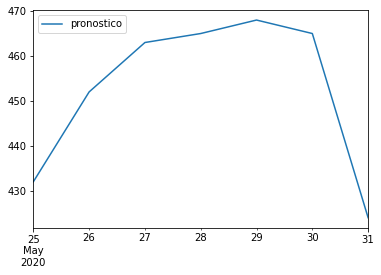

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,435,432
2020-05-26,421,452
2020-05-27,521,463
2020-05-28,442,465
2020-05-29,476,468
2020-05-30,433,465
2020-05-31,404,424


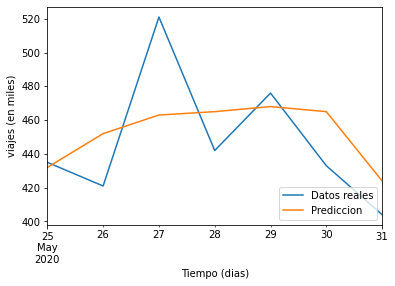

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 25.00 MAE
Resultado del test: 907.29 MSE
Resultado del test: 30.12 RMSE
Resultado del test: 6.65 CVRMSE
Resultado del test: 5.48 MAPE


In [54]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 3.00 MAE
Resultado del test dia 1: 9.00 MSE
Resultado del test dia 1: 3.00 RMSE
Resultado del test dia 1: 0.69 CVRMSE
Resultado del test dia 1: 0.69 MAPE 

Resultado del test dia 2: 31.00 MAE
Resultado del test dia 2: 961.00 MSE
Resultado del test dia 2: 31.00 RMSE
Resultado del test dia 2: 6.86 CVRMSE
Resultado del test dia 2: 6.86 MAPE 

Resultado del test dia 3: 58.00 MAE
Resultado del test dia 3: 3364.00 MSE
Resultado del test dia 3: 58.00 RMSE
Resultado del test dia 3: 12.53 CVRMSE
Resultado del test dia 3: 12.53 MAPE 

Resultado del test dia 4: 23.00 MAE
Resultado del test dia 4: 529.00 MSE
Resultado del test dia 4: 23.00 RMSE
Resultado del test dia 4: 4.95 CVRMSE
Resultado del test dia 4: 4.95 MAPE 

Resultado del test dia 5: 8.00 MAE
Resultado del test dia 5: 64.00 MSE
Resultado del test dia 5: 8.00 RMSE
Resultado del test dia 5: 1.71 CVRMSE
Resultado del test dia 5: 1.71 MAPE 

Resultado del test dia 6: 32.00 MAE
Resultado del test dia 6: 1024.00 MSE
